###### To be run in CMSSW_10_2_3 with adding:
pip install --user joblib scikit-learn==0.20.4

Like v2 but with BTD trained in signal region

# Imports

In [1]:
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

In [2]:
from __future__ import print_function

import h5py, os, sys, datetime, time
sys.path.append('../lib')
from glob import glob
import numpy as np
import scipy as sp
from scipy.special import erf

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
from matplotlib.colors import LogNorm

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import joblib
import pickle
from prettytable import PrettyTable
import ROOT as rt
rt.PyConfig.IgnoreCommandLineOptions = True
rt.gROOT.SetBatch()
rt.gErrorIgnoreLevel = rt.kError

from histo_utilities import create_TH2D, create_TH1D, create_Canvas, make_effiency_plot, rootTH1_to_np
from progressBar import ProgressBar
from cebefo_style import cebefo_style

cebefo_style()


dnd = []

Welcome to JupyROOT 6.12/07


In [3]:
# Thong's DNN imports
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, Lambda
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

Using TensorFlow backend.


In [4]:
from reading_util import *
from writing_util import *
import string_constants as sc

In [5]:
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

## constants CHANGE HERE!!!

In [6]:
Mjj_selection = 1100.

SM_eff = 1e-2 #1e-2
QR_train_share = 0.0 #0.2

# String constants

In [7]:
vae_model = 'pt_normalized'
vae_train_data = 'training_without_pt_cut'

base_dir = os.path.join('/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results',vae_model,vae_train_data)
#file_dir = os.path.join(base_dir,'qcd_sqrtshatTeV_13TeV_PU40_SIGNALREGION_ALL')

file_dir = os.path.join(base_dir,'qcd_sqrtshatTeV_13TeV_PU40')
qr_data = 'qcd_signal'

qr_train_share = str(int(QR_train_share*100))+'pct'
quantile = 'qr_'+str(int(SM_eff*100))+'pct'

fig_dir = os.path.join('fig',vae_model,vae_train_data,qr_data+'_'+qr_train_share+'_qr_train',quantile)
!mkdir -p $fig_dir
print('plotting to', fig_dir)

plotting to fig/pt_normalized/training_without_pt_cut/qcd_signal_0pct_qr_train/qr_1pct


# Function Definitions

In [8]:
loss_scaling = 1.0
Mjj_scaling = 2000.0

def scaleDownMjj(x):
    return (x-2*Mjj_selection)/Mjj_scaling
    #return x
    
def computeDiscriminatingVar_sum(x):
    out = x[:,-6]+x[:,-3]
    out *= loss_scaling #1e9
    return out

def computeDiscriminatingVar_str_sum(l1, l2):
    out = loss_scaling*(l1+l2)
    return out

def computeDiscriminatingVar_min(x):
    out = np.minimum(x[:,-6],x[:,-3])
    out *= loss_scaling #1e9
    return out

def computeDiscriminatingVar_str_min(l1, l2):
    out = loss_scaling*np.minimum(l1,l2)
    return out


# set loss strategy to be used
computeDiscriminatingVar = computeDiscriminatingVar_min
computeDiscriminatingVar_str = computeDiscriminatingVar_str_min

In [9]:
def plot_hist( data, xlabel, ylabel, title, plotname='', legend=[], ylogscale=True ):
    fig = plt.figure( )
    plot_hist_on_axis( plt.gca(), data, xlabel, ylabel, title, legend, ylogscale )
    if legend:
        plt.legend()
    plt.tight_layout()
    fig.savefig(os.path.join(fig_dir, plotname + '_hist.png'))
    plt.close()


def plot_hist_on_axis( ax, data, xlabel, ylabel, title, legend=[], ylogscale=True ):
    bin_num = 70
    alpha = 0.85
    if ylogscale:
        ax.set_yscale('log', nonposy='clip')
    ax.hist( data, bins=bin_num, normed=True, alpha=alpha, histtype='stepfilled', label=legend )
    ax.set_ylabel( ylabel )
    ax.set_xlabel( xlabel )
    ax.set_title( title, fontsize=10 )
    ax.tick_params(axis='both', which='minor', labelsize=8)
    #ax.set_ylim(bottom=1e-7)



In [10]:
def plot_hist_2d( x, y, xlabel, ylabel, title, plotname=''):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()
    im = plot_hist_2d_on_axis( ax, x, y, xlabel, ylabel, title )
    fig.colorbar(im[3])
    plt.tight_layout()
    fig.savefig(os.path.join(fig_dir, plotname + '_hist_2d.png'))
    plt.close()
    #plt.draw()

def plot_hist_2d_on_axis( ax, x, y, xlabel, ylabel, title ):
    im = ax.hist2d(x, y, bins=100, norm=colors.LogNorm())
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_ylim(top=70.)
    return im 

# Get the qcd sample for trainig

In [12]:
qcd_data_total, labels = read_results_to_recarray( file_dir )
#qcd_data_total, labels = read_in_single_result_file(os.path.join(file_dir,'qcd_sqrtshatTeV_13TeV_PU40_SIGNALREGION_ALL_mjj_cut_1100GeV_concat.h5'))
N_evts = qcd_data_total.shape[0]
print("\nnum evts read: ", N_evts)
QCD_xsec = 8.73e-6 #mb
QCD_xsec *= 1e9 #fb # ??????
print('\nLuminosity used for training')
print('{:.2} fb^-1'.format(N_evts/QCD_xsec))
        

reading  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/qcd_sqrtshatTeV_13TeV_PU40
num files in dir: 1995
Labels:
['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss', 'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss']
[--------------------]  0% - ETA: 59.6 h   
num files read in dir  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/qcd_sqrtshatTeV_13TeV_PU40 :  1995

num evts read:  1128088

Luminosity used for training
1.3e+02 fb^-1


In [13]:
#pickle.dump(data_train, open('data/tmp_qcd_sqrtshatTeV_13TeV_PU40.pkl', 'wb'))

In [14]:
# if not os.path.exists(fig_dir):
#     os.makedirs(fig_dir)

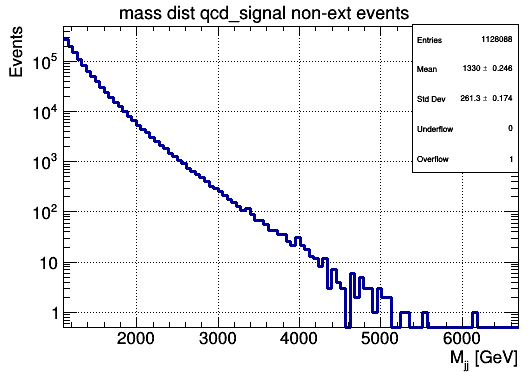

In [15]:
# plot mass dist full dataset
c = create_Canvas(size=(int(800/1.5),int(600/1.5)))
h_Mjj_train = create_TH1D(qcd_data_total['mJJ'], title='mass dist '+qr_data+' non-ext events', axis_title = ['M_{jj} [GeV]','Events'], 
                binning=[100, Mjj_selection, np.max(qcd_data_total[:,0])])

h_Mjj_train.Draw()
c.SetLogy()
c.Draw()
c.SaveAs(os.path.join(fig_dir,qr_data+'_total_mjj_hist.png'))

1128088 events for training


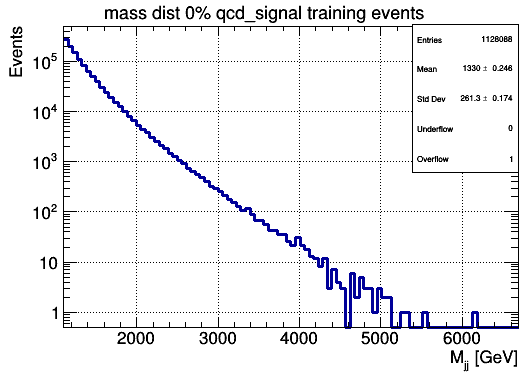

In [16]:
# plot mass dist chosen dataset
#data_train = qcd_data_total[:int(N_evts*QR_train_share)]
data_train = qcd_data_total
print(data_train.shape[0],'events for training')
c = create_Canvas(size=(int(800/1.5),int(600/1.5)))
h_Mjj_train = create_TH1D(data_train['mJJ'], title='mass dist '+str(int(QR_train_share*100))+'% '+qr_data+' training events', axis_title = ['M_{jj} [GeV]','Events'], 
                binning=[100, Mjj_selection, np.max(data_train[:,0])])

h_Mjj_train.Draw()
c.SetLogy()
c.Draw()
c.SaveAs(os.path.join(fig_dir,qr_data+'_'+str(int(QR_train_share*100))+'pct_training_mjj_hist.png'))

### Train the model to predict the cut

# DNN for quantile regression

In [17]:
def quantile_loss(target, pred):
    alpha = 1 - SM_eff
    err = target - pred
    return K.tf.where(err>=0, alpha*err, (alpha-1)*err)

inputs = Input(shape=(1,))
hidden = Dense(100, activation='relu')(inputs)
hidden = Dense(100, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss=quantile_loss, optimizer=Adam(lr=1e-4))
model.summary()

x = np.reshape(data_train['mJJ'], (-1,1))
y = computeDiscriminatingVar(data_train)
print(x.shape)
print(y.shape)

model.fit(scaleDownMjj(x), y, epochs=100, batch_size=10000, 
        verbose=1, validation_split=0.2, shuffle=True,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1),ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)])

date = datetime.date.today()
date_str = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
#model.save('cut_models/dnn_cut_trained_{}.h5'.format(date_str))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total para

2020-02-16 22:16:18.345258: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [18]:
# Compute weights to make it mass agnostic
# hM = h_Mjj_train.Clone('hM')
# print(hM.FindBin(10000))
# scale = np.sqrt(hM.GetMaximum()*hM.GetMinimum(0))
# print(scale)
# hM.Scale(1./scale)

# weights = np.ones_like(data_train[:,0])
# for i, m in enumerate(data_train[:,0]):
#     weights[i] = 1./hM.GetBinContent(hM.FindBin(m))
#     if i%1000000 == 0:
#         print(i)

In [19]:
#gbr_cut = GradientBoostingRegressor(loss='quantile', alpha=1-SM_eff,
#                                n_estimators=250, max_depth=3,
#                                learning_rate=.05, min_samples_leaf=30,
#                                min_samples_split=30,
#                                validation_fraction=0.5,
#                                n_iter_no_change=5,
#                                tol=1e-5,
#                                verbose=2)

In [20]:
#x = np.reshape(data_train[:,0], (-1,1))
#y = computeDiscriminatingVar(data_train)
#gbr_cut = joblib.load('cut_models/gbr_cut_trained_20191028_pval0p5947.joblib','r')
#gbr_cut.fit(x, y, sample_weight=None);

#date = datetime.date.today()
#date_str = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
#joblib.dump(gbr_cut, '../models/gbr_cut_trained_{}.joblib'.format(date_str)) 

((880.0, 8000.0), (0.003769062676585024, 0.5152985772727462))


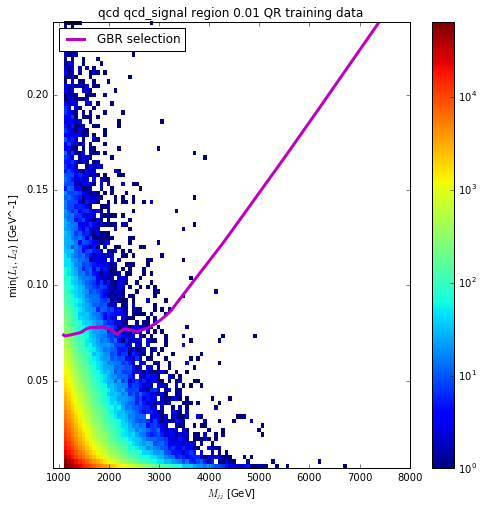

In [21]:
x = np.reshape(data_train[:,0], (-1,1))
plt.figure(figsize=(8, 8))
x_min = Mjj_selection*0.8
x_max = 8000. #np.percentile(x, 99.99)
#x_max = np.max(x)
print(((x_min , x_max), (np.min(y), np.max(y))))
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.percentile(y, 1e2*(1-1e-4)))), 
           norm=LogNorm(), bins=100,
           label='signal data'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
plt.plot(xs, model.predict( np.reshape(scaleDownMjj(xs), (-1,1)) ), '-', color='m', lw=3, label='GBR selection')

plt.ylabel('min($L_1, L_2$) [GeV^-1]')
plt.xlabel('$M_{jj}$ [GeV]')
plt.title('qcd ' + qr_data + ' region '+ str(SM_eff) +' QR training data')
plt.colorbar()
plt.legend(loc='best')
plt.draw()
plt.savefig(os.path.join(fig_dir,'qcd_'+qr_data+'qr_selection_training_hist2d.png'))

In [22]:
#joblib.dump(gbr_cut, 'cut_models/gbr_cut_trained_{}.joblib'.format(date_str)) 

In [23]:
#model.save('cut_models/dnn_cut_trained_{}.h5'.format(date_str))

In [24]:
# from keras.models import load_model
# model = load_model('cut_models/dnn_cut_trained_20191030.h5')

In [25]:
def getSelection(x_Mjj, x_loss):
    cut = model.predict(np.reshape(x_Mjj, (-1,1)))
    return x_loss > cut.flatten()

In [26]:
def plotMassSpectrum(mJJ_pass, mJJ_rej, title=''):
    h_a = create_TH1D(mJJ_pass, 
                      name='h_acc', title='Accepted',
                      binning=binning,
                      opt='overflow'
                     )
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_r = create_TH1D(mJJ_rej, 
                      name='h_rej', title='Rejected',
                      axis_title=['M_{jj} [GeV]', 'Events'],
                      binning=binning,
                      opt='overflow'
                     )
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E', title=title)
    c.pad1.SetLogy()
    c.pad2.SetLogy()

    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(8)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

    c.Draw()
    return c

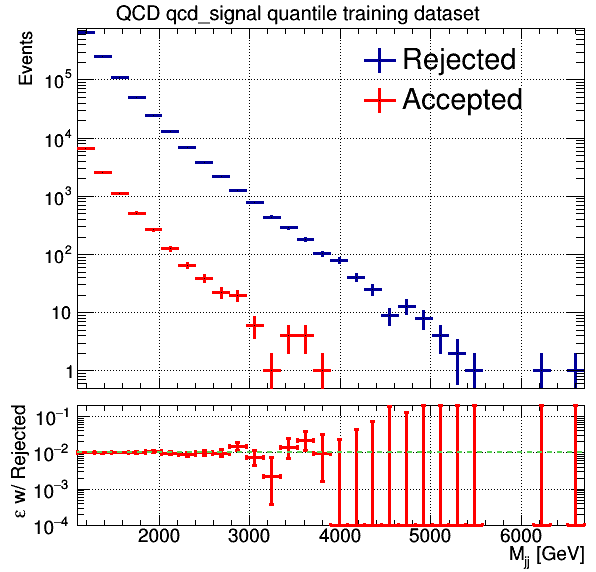

In [27]:
x = x.flatten()
binning=[30, Mjj_selection, np.max(x)]

sel = getSelection(scaleDownMjj(x), y)

c = plotMassSpectrum(x[sel], x[np.logical_not(sel)], 'QCD ' + qr_data + ' quantile training dataset')
h_a = c.h_list[1]
h_r = c.h_list[0]
c.SaveAs(os.path.join(fig_dir,'qcd_'+qr_data+'_mjj_selected_vs_rejected_hist.png'))

# Define and test Hypotesis test

In [28]:
def HypotesisTets(h_a_bin_content, h_r_bin_content, eff, N_asymov = 10000, max_N_asymov = 1e7, show_hist=True):
    nu = eff*h_r_bin_content/(1-eff)

    probs_obs = sp.stats.poisson.pmf(h_a_bin_content.astype(np.int), nu)
    probs_obs = np.where(probs_obs < 1e-10, np.full_like(probs_obs, 1e-10), probs_obs)
    s_obs = np.sum(-np.log(probs_obs), axis=-1)
    print('S obs:', s_obs)

    N_worse = 0
    N_tot = 0
    loops = 0
    # toy generation
    while N_worse < 25 and N_tot < max_N_asymov:
        loops += 1
        if loops > 1 and loops%10 == 0:
            print(N_tot, N_worse)
        if loops == 10:
            print('Increasing by a factor 5 the number of asymov per loop')
            N_asymov *=5
        o_asymov = np.random.poisson(nu, (N_asymov, nu.shape[0]))
        probs = sp.stats.poisson.pmf(o_asymov, nu)
        probs = np.where(probs < 1e-10, np.full_like(probs, 1e-10), probs)
        nll = -np.log(probs)
        s_asymov = np.sum(nll, axis=-1)

        N_worse += np.sum(s_asymov > s_obs) # compare accepted-stats and toy-stats
        N_tot += N_asymov

        if max_N_asymov/N_tot < 25 and (N_worse * (max_N_asymov/N_tot) < 25):
            print('Will never have enough stat - giving up.')
            p_val = max(1, N_worse)/float(N_tot)
            return p_val

    print('Test stat reached after {} loops'.format(loops))

    p_val = max(1, N_worse)/float(N_tot)
    
    if show_hist:
        plt.figure()
        binContent, _, _ = plt.hist(s_asymov, label='Distribution assuming eff={:.1f}%'.format(100*eff))
        plt.plot([s_obs, s_obs], [0,np.max(binContent)], label='Observed')
        plt.legend(loc='best')
        plt.xlabel('Test statistic')
        plt.ylabel('Entries')
        plt.title('hypothesis test QR training qcd '+qr_data+ ', p-val = ' + str(p_val) )
        plt.savefig(os.path.join(fig_dir,'qcd_'+qr_data+'qr_selection_hist2d.png'))

    return p_val

S obs: 53.09567272343004
Test stat reached after 1 loops


0.6354

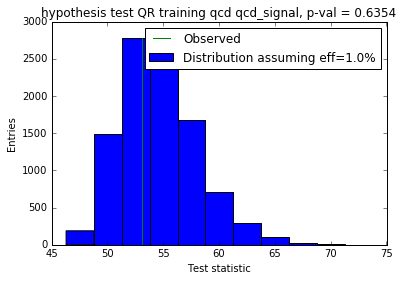

In [29]:
h_a_bin_content, _ = rootTH1_to_np(h_a)
h_r_bin_content, _ = rootTH1_to_np(h_r)
HypotesisTets(h_a_bin_content, h_r_bin_content, SM_eff, N_asymov=10000)

# Analyze signal region

In [30]:
print(base_dir)

sample_loc = {'qcdSigExt': base_dir + '/qcd_sqrtshatTeV_13TeV_PU40_EXT_ALL',  #_ALL # _ext + _ext2
              'GtoWW15': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_1.5TeV',
              'GtoWW20': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_2.0TeV',
              'GtoWW25': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_2.5TeV',
              'GtoWW30': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_3.0TeV',
              'GtoWW35': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_3.5TeV',
              'GtoWW40': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_4.0TeV',
              'GtoWW45': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_4.5TeV',
              'AtoHZ': base_dir + '/AtoHZ_to_ZZZ_13TeV_PU40/',
              'GtoTTBroad': base_dir + '/RSGraviton_tt_BROAD_13TeV_PU40',
              'GtoTTNarr': base_dir + '/RSGraviton_tt_NARROW_13TeV_PU40'
             }

sample_label = {'qcdSigExt':r'QCD ext signal',
                'GtoWW15':r'$G(1.5 TeV)\to WW$',
                'GtoWW20':r'$G(2.0 TeV)\to WW$',
                'GtoWW25':r'$G(2.5 TeV)\to WW$',
                'GtoWW30':r'$G(3.0 TeV)\to WW$',
                'GtoWW35':r'$G(3.5 TeV)\to WW$',
                'GtoWW40':r'$G(4.0 TeV)\to WW$',
                'GtoWW45':r'$G(4.5 TeV)\to WW$',
                'AtoHZ':r'$A \to HZ \to ZZZ$',
                'GtoTTBroad':r'$G \to TT broad$',
                'GtoTTNarr':r'$G \to TT narrow$'
               }

sample_label_ROOT = {'qcdSigExt':'QCD ext signal',
                'GtoWW15':'G(1.5 TeV) to WW$',
                'GtoWW20':'$G(2.0 TeV) to WW$',
                'GtoWW25':'$G(2.5 TeV) to WW$',
                'GtoWW30':'$G(3.0 TeV) to WW$',
                'GtoWW35':'$G(3.5 TeV) to WW$',
                'GtoWW40':'$G(4.0 TeV) to WW$',
                'GtoWW45':'$G(4.5 TeV) to WW$',
                'AtoHZ':'A to HZ to ZZZ',
                'GtoTTBroad':'G to TT broad',
                'GtoTTNarr':'G to TT narrow'
               }

SM_samples = ['qcdSigExt']
BSM_samples = ['GtoWW15', 'GtoWW20', 'GtoWW25', 'GtoWW30', 'GtoWW35', 'GtoWW40','GtoWW45','AtoHZ','GtoTTBroad', 'GtoTTNarr']

# nGenEvts are updated when reading the data in -> correspond to actual numbers
sample_nGenEvts = {'qcdSigExt': (3826+2873)*10000, # TODO: adapt numbers! 
                   'GtoWW15': 99*10000,
                   'GtoWW20': 92*10000,
                   'GtoWW25': 92*10000,
                   'GtoWW30': 92*10000,
                   'GtoWW35': 92*10000,
                   'GtoWW40': 97*10000,
                   'GtoWW45': 97*10000,
                   'AtoHZ': 98*1000,
                   'GtoTTBroad': 98*1000,
                   'GtoTTNarr': 96*1000
                  }

sample_xsec = {'qcdSigExt': 8734.0 #pb
              }

/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut


In [31]:
print(sample_loc.keys())

['qcdSigExt', 'GtoTTBroad', 'GtoTTNarr', 'GtoWW4', 'AtoHZ', 'GtoWW1', 'GtoWW2', 'GtoWW3']


In [32]:
lumi_generated = sample_nGenEvts['qcdSigExt']/sample_xsec['qcdSigExt']
print('Lumi: {:.1f} pb^-1'.format(lumi_generated))

Lumi: 7670.0 pb^-1


### Get the data

In [33]:
result_data = {}
data = {}
sample_eff = {}
table = PrettyTable()
table.field_names = ['Sample', 'Trg evts', 'Eff. trg [%]', 'VAE sel. evts', 'Eff VAE [%]']

In [34]:
# read in data
labels = None
for n, file_dir in sample_loc.iteritems():
    print(n)
    if n == 'qcdSigExt':
        #sample = qcd_data_total[int(N_evts*QR_train_share):] # all of qcd already read in
         sample, labels, N_evts = read_in_data( file_dir )
    else:
        sample, labels, N_evts = read_in_data( file_dir )
    result_data[n] = sample
    #sample_nGenEvts[n] = sample.shape[0]


qcdSigExt
reading  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/qcd_sqrtshatTeV_13TeV_PU40_EXT_ALL
reading  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/qcd_sqrtshatTeV_13TeV_PU40_EXT_ALL/qcd_sqrtshatTeV_13TeV_PU40_EXT
reading  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/qcd_sqrtshatTeV_13TeV_PU40_EXT_ALL/qcd_sqrtshatTeV_13TeV_PU40_EXT2
num files in dir: 6775
Labels:
['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss', 'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss']
[--------------------]  0% - ETA:188.1 h   
num files read in dir  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/qcd_sqrtshatTeV_13TeV_PU40_EXT_ALL :  6775
GtoTTBroad
reading  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_with

In [35]:
print(labels)

['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss', 'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss']


In [36]:
# compute discriminating var and selection for data, print in table
for n, file_dir in sample_loc.iteritems():
    x = result_data[n]
    dVar = computeDiscriminatingVar(x)
    sel = getSelection(scaleDownMjj(x[:,0]), dVar)
    x = np.column_stack((x, dVar, sel))
    print(x.shape[0])
    sample_eff[n] = float(x.shape[0])/sample_nGenEvts[n] # sample_eff == 1 if trigger eff = 100%

    dt = [(str(s), '<f4') for s in labels + ['dVar']]
    dt += [('sel', '?')]
    data[n] = np.array(list(zip(*x.T)), dtype=dt)
    
    eff = '{:.2f}'.format(100.0*np.sum(data[n]['sel'])/float(data[n]['sel'].shape[0]))
    table.add_row([n, data[n]['sel'].shape[0], '{:.1f}'.format(100.0*sample_eff[n]), np.sum(data[n]['sel']), eff])

print(table)

2099648
64822
63572
585624
63128
367557
474653
518954
+------------+----------+--------------+---------------+-------------+
|   Sample   | Trg evts | Eff. trg [%] | VAE sel. evts | Eff VAE [%] |
+------------+----------+--------------+---------------+-------------+
| qcdSigExt  | 2099648  |     3.1      |     21168     |     1.01    |
| GtoTTBroad |  64822   |     66.1     |     13622     |    21.01    |
| GtoTTNarr  |  63572   |     66.2     |     13431     |    21.13    |
|   GtoWW4   |  585624  |     60.4     |     59885     |    10.23    |
|   AtoHZ    |  63128   |     64.4     |      9936     |    15.74    |
|   GtoWW1   |  367557  |     37.1     |     25876     |     7.04    |
|   GtoWW2   |  474653  |     51.6     |     65665     |    13.83    |
|   GtoWW3   |  518954  |     56.4     |     71738     |    13.82    |
+------------+----------+--------------+---------------+-------------+


In [37]:
print(sample_eff)

{'qcdSigExt': 0.0313427078668458, 'GtoTTNarr': 0.6622083333333333, 'GtoWW1': 0.37126969696969697, 'GtoTTBroad': 0.6614489795918367, 'GtoWW4': 0.6037360824742268, 'AtoHZ': 0.6441632653061224, 'GtoWW2': 0.5159271739130434, 'GtoWW3': 0.5640804347826087}


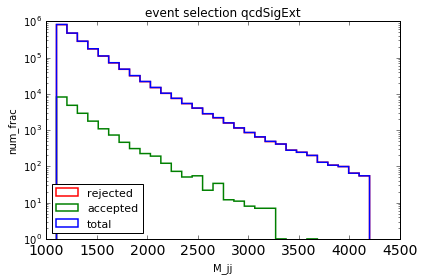

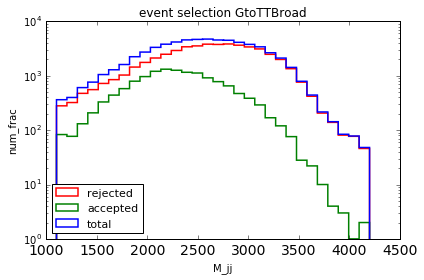

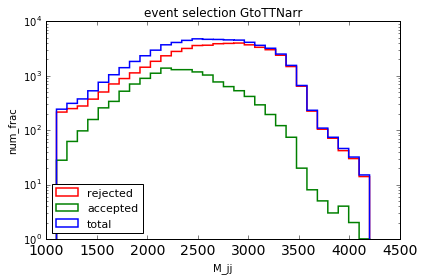

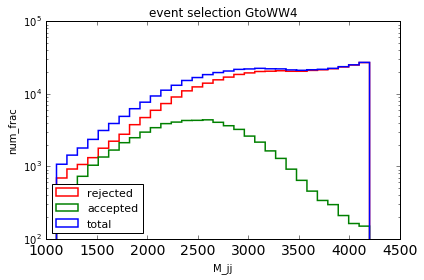

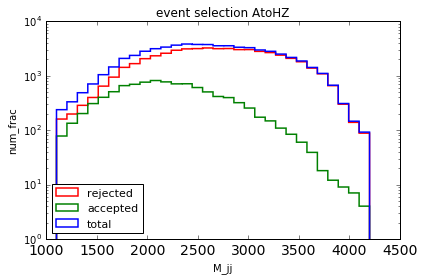

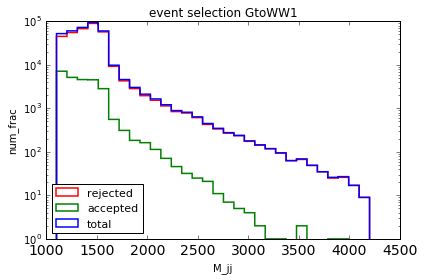

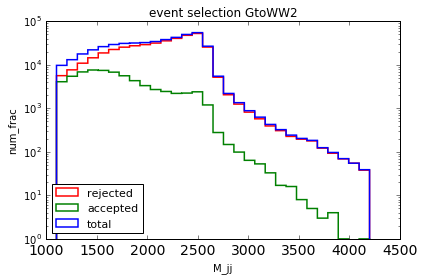

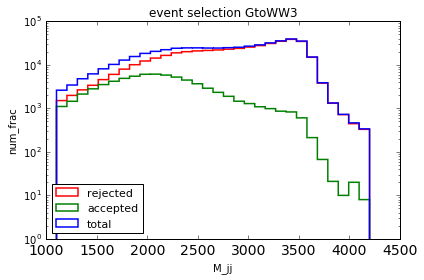

In [38]:
# compute bin counts for selected, rejected and total for combine input
import plotting_util as pu
reload(pu)
hist_data = [] # num signals X 2 (h_t, h_a) X num_bins (len(bin_edges)-1)
file_bin_counts = h5py.File(os.path.join(fig_dir,'vae_boost_bin_counts.h5'),'w')

bin_edges = np.linspace(1100,4200,31)

for dataset,file_dir in sample_loc.iteritems():
    x = data[dataset]
    accepted = x[ x['sel'] ]
    rejected = x[ ~x['sel'] ]
    xx = [x['mJJ'], accepted['mJJ'], rejected['mJJ']]
    plot_name = dataset+'_event_selection'
    [h_t, h_a, h_r], _ = \
        pu.plot_hist( xx, xlabel='M_jj', bins=bin_edges, title='event selection ' + dataset, fig_dir=fig_dir, plot_name=plot_name, legend=['total','accepted','rejected'], normed=False)
    hist_data.append( np.stack( (h_t,h_a) ) )
    

file_bin_counts.create_dataset('bin_counts', data=np.asarray(hist_data))
file_bin_counts.create_dataset('bin_edges',data=bin_edges)
file_bin_counts.create_dataset('dataset_names',data=sample_loc.keys())
file_bin_counts.close()

In [39]:
# for n, label in sample_label.iteritems():
#     x = data[n]
#     y = computeDiscriminatingVar_str(x['j1TotalLoss'],x['j2TotalLoss'])
#     plot_hist_2d(x['mJJ'],y, 'mass jj', 'L1+L2', 'mass vs loss ' + label, n)


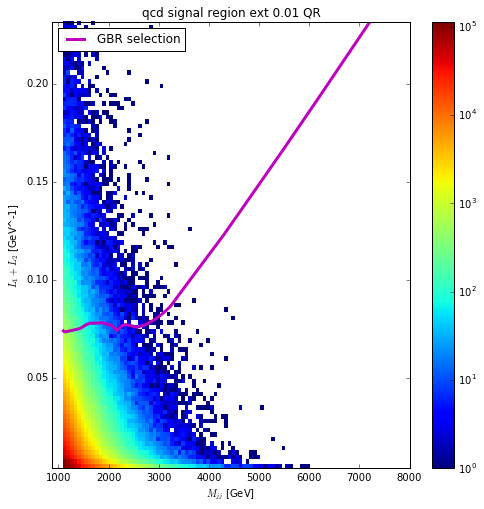

In [40]:
x = np.reshape(data['qcdSigExt']['mJJ'], (-1,1))
y = computeDiscriminatingVar_str(data['qcdSigExt']['j1TotalLoss'], data['qcdSigExt']['j2TotalLoss'])

plt.figure(figsize=(8, 8))
x_min = Mjj_selection*0.8
x_max = 8000.
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.percentile(y, 1e2*(1-1e-4)))), 
           norm=LogNorm(), bins=100,
           label='qcd signal ext'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
plt.plot(xs, model.predict(np.reshape(scaleDownMjj(xs), (-1,1))), '-', color='m', lw=3, label='GBR selection')

plt.ylabel('$L_1 + L_2$ [GeV^-1]')
plt.xlabel('$M_{jj}$ [GeV]')
plt.title('qcd signal region ext '+ str(SM_eff) +' QR')
plt.colorbar()
plt.legend(loc='best')
plt.draw()
plt.savefig(os.path.join(fig_dir,'qcd_'+qr_data+'qr_selection_applied_hist2d.png'))

### Define utilitities

In [41]:
def plotMassSpectrum_wSig(h_r, h_a, h_a_sig, name_BSM, lumi_text, p_val):
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()
    h_r.SetLineWidth(2)
    
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_a.SetLineWidth(2)
    
    h_a_sig.SetFillStyle(3001)
    h_a_sig.SetFillColor(8)
    h_a_sig.SetLineWidth(0)

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-3, None], draw_opt = 'E')
    c.pad1.SetLogy()
    c.pad1.cd()
    h_a_sig.Draw('SAME')
    c.leg.AddEntry(h_a_sig, 'Acc. '+sample_label_ROOT[name_BSM], 'f')
    
    latex = rt.TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextAlign(31)
    t = c.pad1.GetTopMargin()
    r = c.pad1.GetRightMargin()
    latex.DrawLatex(1-r, 1-0.85*t, lumi_text)

    c.pad2.SetLogy()
    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(6)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    
    latex.SetTextSize(0.1)
    latex.SetTextAlign(13)
    l = c.pad2.GetLeftMargin()
    t = c.pad2.GetTopMargin()
    latex.DrawLatex(l*1.1, 1-2*t, 'p-value: {:.1f} %'.format(100*p_val))

    c.Draw()
    return c

## Find the p-value as a function of xsec

In [42]:
lumi = 2000 #pb^-1

N_asymov = 10000
N_exp_per_xsec = 5

In [43]:
dic_p_val = {}
rt.gROOT.SetBatch(True)



GtoWW1
xsec BSM 1.0e-05 pb
Experiment: 0
S obs: 46.19282694017272
Test stat reached after 1 loops
plotting GtoWW11.00e-05pb_L2000pb-1_wEff
Experiment: 1
S obs: 44.739912912459786
Test stat reached after 1 loops
Experiment: 2
S obs: 49.736225258256944
Test stat reached after 1 loops
Experiment: 3
S obs: 54.122349661715575
Test stat reached after 1 loops
Experiment: 4
S obs: 49.82011609490962
Test stat reached after 1 loops
xsec BSM 3.2e-05 pb
Experiment: 0
S obs: 47.64108398514078
Test stat reached after 1 loops
plotting GtoWW13.16e-05pb_L2000pb-1_wEff
Experiment: 1
S obs: 46.59942083868505
Test stat reached after 1 loops
Experiment: 2
S obs: 49.65908150625933
Test stat reached after 1 loops
Experiment: 3
S obs: 44.04301449944404
Test stat reached after 1 loops
Experiment: 4
S obs: 57.477286977965676
Test stat reached after 1 loops
xsec BSM 1.0e-04 pb
Experiment: 0
S obs: 48.13495908986226
Test stat reached after 1 loops
plotting GtoWW11.00e-04pb_L2000pb-1_wEff
Experiment: 1
S obs: 48

S obs: 51.344267860991444
Test stat reached after 1 loops
Experiment: 3
S obs: 45.365897927564674
Test stat reached after 1 loops
Experiment: 4
S obs: 46.83548998320776
Test stat reached after 1 loops
xsec BSM 1.0e-04 pb
Experiment: 0
S obs: 45.99377121174505
Test stat reached after 1 loops
plotting GtoTTNarr1.00e-04pb_L2000pb-1_wEff
Experiment: 1
S obs: 43.58753290805967
Test stat reached after 1 loops
Experiment: 2
S obs: 52.35833541161193
Test stat reached after 1 loops
Experiment: 3
S obs: 48.71333339321741
Test stat reached after 1 loops
Experiment: 4
S obs: 44.37881610312652
Test stat reached after 1 loops


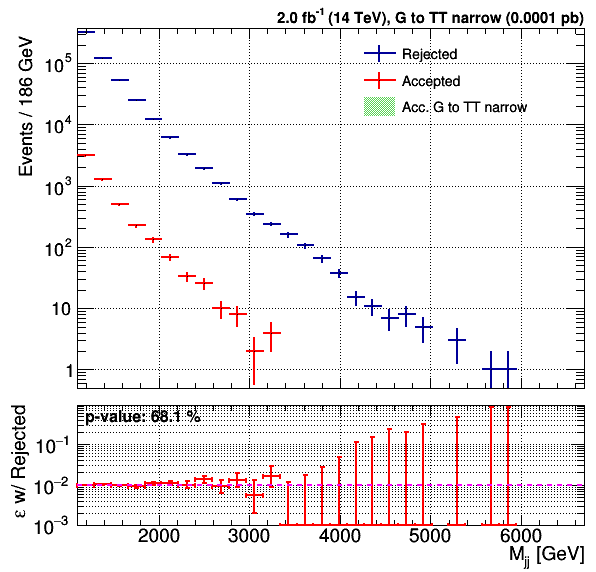

In [44]:
for name_BSM in BSM_samples: # for each BSM signal
    print('\n\n'+name_BSM)
    dic_p_val[name_BSM] = []
    # increasing cross section (p should be large at small xsec), xsec = 1 i.e. 10^1
    for xsec_BSM in np.logspace(-5, -4, 3): #(-4, 1, 8, endpoint=True): 
        print('xsec BSM {:.1e} pb'.format(xsec_BSM))
        lumi_text = '{:.1f} fb^{{-1}} (14 TeV), '.format(1e-3*lumi) + sample_label_ROOT[name_BSM] + ' ({:.2} pb)'.format(xsec_BSM)

        p_val_test = []
        for i_exp in range(N_exp_per_xsec): # for each xsec, do 5 experiments
            print('Experiment:', i_exp)
            d_obs = np.zeros((0,2))

            sample_xsec[name_BSM] = xsec_BSM
            for n in SM_samples + [name_BSM]: # create dataset with background and signal
                nExpEvts = lumi*sample_xsec[n]*sample_eff[n] # num expected events (?)
                nEvts = np.random.poisson(nExpEvts)
                if data[n]['mJJ'].shape[0] < nEvts:
                    print('[WARNING] ' + n + ' re-use factor = {:.2f}'.format(float(nEvts)/data[n]['mJJ'].shape[0]))
                evtsIdx = np.random.randint(0, data[n]['mJJ'].shape[0], size=(nEvts,))

                # take nEvts (mass and selection) at random from dataset
                d_aux = np.column_stack((data[n]['mJJ'][evtsIdx], data[n]['sel'][evtsIdx])) 
                d_obs = np.concatenate((d_obs, d_aux)) # concatenate background and signal

            h_a = create_TH1D(d_obs[:, 0][d_obs[:,1].astype(np.bool)], 
                                 name='h_acc', title='Accepted',
                                 binning=binning,
                                 opt='overflow')

            h_r = create_TH1D(d_obs[:, 0][np.logical_not(d_obs[:,1]).astype(np.bool)], 
                                 name='h_rej', title='Rejected',
                                 axis_title=['M_{jj} [GeV]', ''],
                                 binning=binning,
                                 opt='overflow'
                                )
            h_r.SetYTitle('Events / {:.0f} GeV'.format(h_r.GetBinWidth(1)))

            h_a_bin_content, _ = rootTH1_to_np(h_a)
            h_r_bin_content, _ = rootTH1_to_np(h_r)
            # do hypothesis test with mixed background-signal dataset
            p_val = HypotesisTets(h_a_bin_content, h_r_bin_content, SM_eff, N_asymov = N_asymov, show_hist=False)
            p_val_test.append(p_val)

            if i_exp > 3 and np.max(p_val_test) == 0:
                break

            if i_exp == 0:
                h_a_sig = create_TH1D(d_obs[-nEvts-1:, 0][d_obs[-nEvts-1:, 1].astype(np.bool)], 
                                     name='h_acc', title='Accepted',
                                     binning=binning,
                                     opt='overflow')
                
                c = plotMassSpectrum_wSig(h_r, h_a, h_a_sig, name_BSM, lumi_text, p_val)
                fig_name = name_BSM + '{:1.2e}'.format(xsec_BSM) + 'pb' + '_L' + str(lumi) + 'pb-1_wEff'
                print('plotting', fig_name)
                c.SaveAs(os.path.join(fig_dir,fig_name + '.png'))
                #c.Draw()
                
        aux = [xsec_BSM] + list(np.percentile(p_val_test, [2.5, 16, 50, 84, 97.5]))
        dic_p_val[name_BSM].append(aux)
    

# Make the p-value plot

In [45]:
sample_col = {
              'GtoWW1':'b',
              'GtoWW2':'g',
              'GtoWW3':'r',
              'GtoWW4':'m',
              'AtoHZ':'y',
              'GtoTTBroad':'k',
              'GtoTTNarr':'c'
             }

[1.00000000e-05 3.16227766e-05 1.00000000e-04] [0.6612 0.537  0.6809]
[1.00000000e-05 3.16227766e-05 1.00000000e-04] [0.2402 0.4806 0.5016]
[1.00000000e-05 3.16227766e-05 1.00000000e-04] [0.5889 0.2845 0.6768]
[1.00000000e-05 3.16227766e-05 1.00000000e-04] [0.6414 0.4765 0.5564]
[1.00000000e-05 3.16227766e-05 1.00000000e-04] [0.7253 0.2986 0.3665]
[1.00000000e-05 3.16227766e-05 1.00000000e-04] [0.5181 0.7184 0.3195]
[1.00000000e-05 3.16227766e-05 1.00000000e-04] [0.633  0.5367 0.4562]


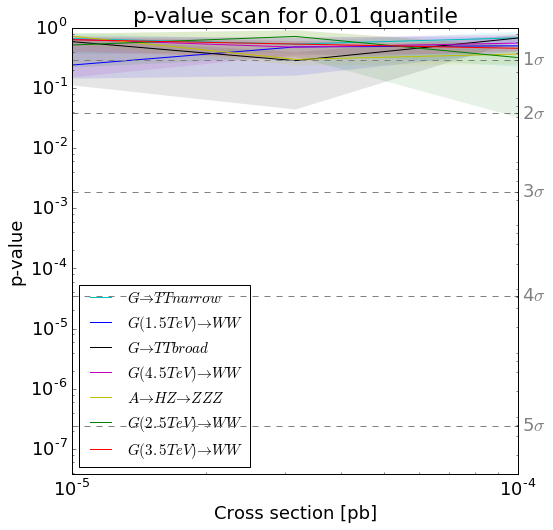

In [46]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(8,8))


for n, val_aux in dic_p_val.iteritems():
    val_aux = np.array(val_aux)
    x_sec = val_aux[:, 0]
    quant = val_aux[:, 1:]
    
    ax1.plot(x_sec, quant[:, 2], color=sample_col[n], label=sample_label[n])
    print(x_sec, quant[:,2])
    ax1.fill_between(x_sec, quant[:, 1], quant[:, 3], color=sample_col[n], alpha = 0.1, lw=0)
#     ax1.fill_between(x_sec, quant[:, 0], quant[:, 4], color=sample_col[n], alpha = 0.1, lw=0)
    
    
plt.xscale('log')
plt.xlabel('Cross section [pb]')
plt.yscale('log')
plt.ylabel('p-value')
plt.ylim(1 - erf(5.5/np.sqrt(2)), 1)
plt.legend(loc='lower left',prop={'size': 15})
ax2 = ax1.twinx()
for i in range(1, 6):
    p = 1 - erf(i/np.sqrt(2))
    ax2.plot([x_sec[0], x_sec[-1]], 2*[p], '--', color='grey')
plt.yscale('log')
plt.title('p-value scan for ' + str(SM_eff) + ' quantile')
ax2.set_yticks(1 - erf(np.arange(1,6)/np.sqrt(2)))
ax2.set_yticklabels(['{}$\sigma$'.format(i) for i in range(1,6)])
ax2.tick_params(axis='y', labelcolor='grey')
fig.savefig(os.path.join(fig_dir,'pValueScan_L' + str(lumi) + 'pb-1.png'), bbox_inches='tight')